## 準備

### サンプルデータのダウンロード
UCIで公開されているstudent performanceを使います。

https://archive.ics.uci.edu/ml/datasets/student+performance

In [1]:
import requests
import zipfile
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

In [2]:
%precision 3

'%.3f'

In [3]:
# student.zipをダウンロード
response = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip')
with open ('student.zip', 'wb') as f:
    f.write(response.content)
    f.close()

In [4]:
# カレントディレクトリに解凍
zfile = zipfile.ZipFile('student.zip')
zfile.extractall('.')

### サンプルデータをPandasのデータフレームにロード

In [5]:
# 全カラムを表示させる
pd.set_option('display.max_columns', None)

In [6]:
# 数学の成績(student-mat.csv)をロード
student_math_data = pd.read_csv('student-mat.csv', delimiter=';')
student_math_data = student_math_data[student_math_data['absences'] < 30] # 欠席回数30以上は外れ値として除外

student_math_data

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10
5,GP,M,16,U,LE3,T,4,3,services,other,reputation,mother,1,2,0,no,yes,yes,yes,yes,yes,yes,no,5,4,2,1,2,5,10,15,15,15
6,GP,M,16,U,LE3,T,2,2,other,other,home,mother,1,2,0,no,no,no,no,yes,yes,yes,no,4,4,4,1,1,3,0,12,12,11
7,GP,F,17,U,GT3,A,4,4,other,teacher,home,mother,2,2,0,yes,yes,no,no,yes,yes,no,no,4,1,4,1,1,1,6,6,5,6
8,GP,M,15,U,LE3,A,3,2,services,other,home,mother,1,2,0,no,yes,yes,no,yes,yes,yes,no,4,2,2,1,1,1,0,16,18,19
9,GP,M,15,U,GT3,T,3,4,other,other,home,mother,1,2,0,no,yes,yes,yes,yes,yes,yes,no,5,5,1,1,1,5,0,14,15,15


## 2.1 例題: 種子数の統計モデリング
種子数の代わりに、各生徒の欠席回数(absences)を数えたカウントデータを使います。

In [7]:
# 欠席回数(カウントデータ)を目的変数として使う
data = student_math_data['absences']
data

0       6
1       4
2      10
3       2
4       4
5      10
6       0
7       6
8       0
9       0
10      0
11      4
12      2
13      2
14      0
15      4
16      6
17      4
18     16
19      4
20      0
21      0
22      2
23      0
24      2
25     14
26      2
27      4
28      4
29     16
       ..
365     4
366     0
367     0
368     0
369    10
370     4
371     3
372     8
373    14
374     0
375     2
376     4
377     4
378     0
379    17
380     4
381     5
382     2
383     0
384    14
385     2
386     7
387     0
388     0
389     0
390    11
391     3
392     3
393     0
394     5
Name: absences, dtype: int64

In [8]:
# dataにはいくつのデータが含まれるのか？
len(data) # data.count(), data.size

389

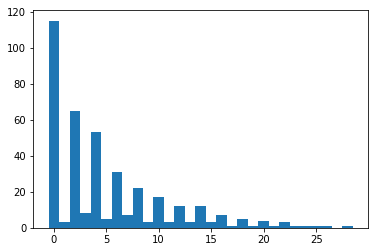

In [9]:
# ヒストグラム
plt.hist(data, bins=np.arange(-0.5, 29.5))
plt.show()

In [10]:
# 欠席数の分布が偶数に偏っている。
# 数学の授業は2時間連続となっており、1日休むと2回欠席したことになる(欠席数1の人は遅刻して2時間目の授業から出席した)、などが考えられる。
# そこで2で割って切り捨てることで、欠席数0〜1の人は0回、2〜3の人は1回、・・・となるようにする。
data = pd.Series(data / 2, dtype=int)

In [11]:
# dataを要約せよ
print(data.describe())
print('中央値: ', data.median())
print('第１四分位数: ', data.quantile(0.25))
print('第３四分位数: ', data.quantile(0.75))

count    389.000000
mean       2.470437
std        2.818802
min        0.000000
25%        0.000000
50%        2.000000
75%        4.000000
max       14.000000
Name: absences, dtype: float64
中央値:  2.0
第１四分位数:  0.0
第３四分位数:  4.0


In [12]:
print('平均: {}'.format(data.mean())) # 平均: 2.47
print('分散: {}'.format(data.var())) # 分散: 7.95

平均: 2.4704370179948585
分散: 7.945644396151923


In [13]:
# 度数分布
data.value_counts()

0     118
1      73
2      58
3      38
4      25
5      20
7      15
6      15
8       8
9       6
10      5
11      4
12      2
14      1
13      1
Name: absences, dtype: int64

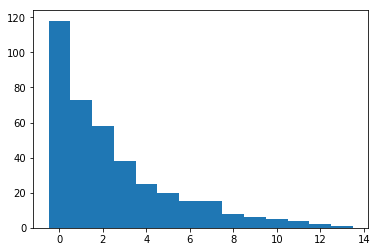

In [14]:
# ヒストグラム
plt.hist(data, bins=np.arange(-0.5, 14.5))
plt.show()

In [15]:
# 標本分散
data.var()

7.946

In [16]:
# 標本標準偏差
data.std() # math.sqrt(data.var())

2.819

## 2.2 データと確率分布の対応関係をながめる
- 生徒の欠席回数の平均は2.47回

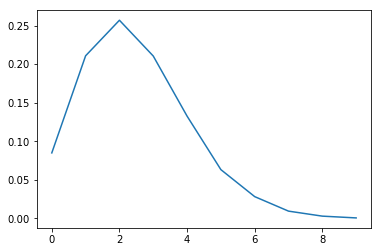

In [17]:
# 平均2.47のポアソン分布
poisson_values = np.random.poisson(lam=2.47, size=10000)
# poisson_values = poisson.rvs(2.47, size=10000)
prod = (pd.value_counts(poisson_values) / 10000).sort_index()
plt.plot(prod.index, prod.values)
plt.show()

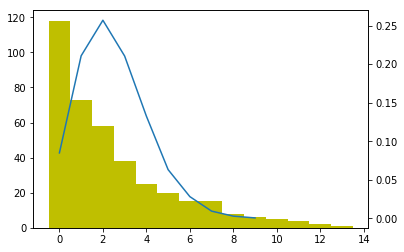

In [18]:
# ヒストグラムと重ねる
fig, ax1 = plt.subplots()
plt.hist(data, bins=np.arange(-0.5, 14.5), color=['y'])
ax2 = ax1.twinx()
ax2.plot(prod)
plt.show()

## 2.3 ポアソン分布とは何か？

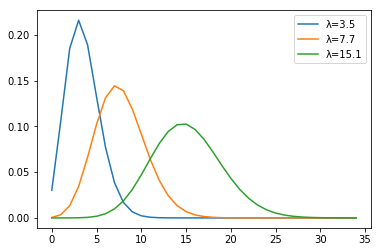

In [19]:
# 様々な平均(λ)のポアソン分布。λ∈{3.5, 7.7, 15.1}
prod1 = [poisson.pmf(i, 3.5) for i in range(35)]
prod2 = [poisson.pmf(i, 7.7) for i in range(35)]
prod3 = [poisson.pmf(i, 15.1) for i in range(35)]

plt.plot(range(35), prod1, label='λ=3.5')
plt.plot(range(35), prod2, label='λ=7.7')
plt.plot(range(35), prod3, label='λ=15.1')

plt.legend(loc='best')

plt.show()

## 2.4 ポアソン分布のパラメーターの最尤推定

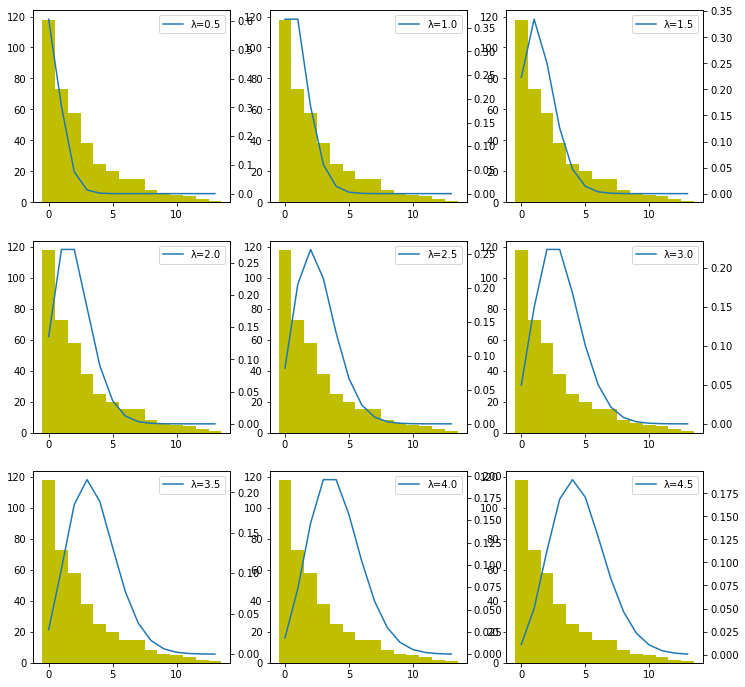

In [20]:
# λが0.5から4.0まで0.5刻みでλを変え、各λのポアソン分布をプロットする
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i in range(9):
    lam = 0.5*(i+1)
    prod = [poisson.pmf(i, lam) for i in range(14)]
    
    ax1 = axes[int(i/3), i%3]
    ax1.hist(data, bins=np.arange(-0.5, 14.5), color=['y'])
    
    ax2 = ax1.twinx()
    ax2.plot(prod, label='λ={:.1f}'.format(lam))
    ax2.legend(loc='best')
plt.show()

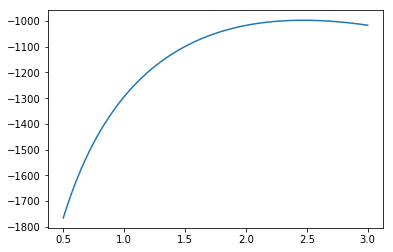

In [21]:
# λが0.5から3.0まで0.01刻みでλを変え、各λでの対数尤度をプロットする
x = np.arange(0.50, 3.01, 0.01)
y = [sum(poisson.logpmf(data, lam)) for lam in x]
plt.plot(x, y)
plt.show()

In [22]:
print('最大対数尤度: {}'.format(max(y)))
print('最尤推定値: {}'.format(x[y.index(max(y))]))

最大対数尤度: -996.8300191271965
最尤推定値: 2.4700000000000015


### 2.4.1 擬似乱数と最尤推定値のばらつき

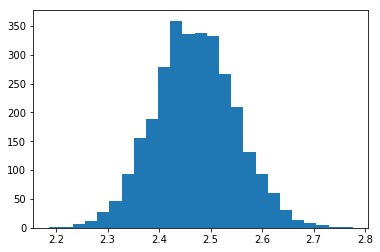

In [23]:
# 平均2.47のポアソン分布を3000回試行し、各試行での最尤推定値(=標本平均)をヒストグラムにプロット
y = [np.random.poisson(lam=2.47, size=len(data)).mean() for i in range(3000)]
plt.hist(y, bins=25)
plt.show()